# Exploratory analysis of the dataset

In this notebook, we explore the dataset proposed for the exercise. According to the result of the exploration, a specific approach will be used to solve it.

In [42]:
import sys
sys.path.insert(0, "../src/main/python/")
from models import ConfigManager
from models import TextTokenizer
from models import TextNormalizer
from models import Phraser

import fasttext
import pandas as pd
pd.set_option('display.max_colwidth', None)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary

class LanguageIdentifier(object):
    """Wrapper for FastText Language Identifier models"""

    def __init__(self, model_path=None):
        """Initializes object loading model from saved artifact"""
        self._model = fasttext.load_model(model_path)

    def predict(self, texts):
        """Gets texts and return its corresponding language identifiers"""
        languages = self._model.predict(texts, k=1)[0]
        languages = [language[0].replace('__label__', '') for language in languages]
        return languages

regex_filters = [
    "^rt$", # retweet
    "^…$", # dots
    "^n?https?.+$", # urls
    "^(u.+|n)$", # unicode
    "^[.]+$", # dots
    "^[0-9]+$" # numbers
]

tokenizer = TextTokenizer(
    filter_punctuation=True,
    regex_filters=regex_filters,
    lower=True,
    stopwords_language='english'
)

normalizer = TextNormalizer(
    normalize_unicode=True,
    remove_break_lines=True
)

language_identifier = LanguageIdentifier(
    model_path="../../lid.176.ftz"
)

## Loading the dataset. First checkings
- Checking fields of the dataset. There are two fields: Tweet with texts and ISIS Flags with labels
- Checking the number of rows. The dataset contains 139774 rows ~140000
- Checking set of labels. As expected, there are two available values for the ISIS Flag field: 1/0

In [44]:
dataset = pd.read_csv('../data/Tweets.csv', sep=',', encoding='utf8')
print('columns:', dataset.columns)
print('#rows: ', len(dataset))
dataset.head()

columns: Index(['ISIS Flag', 'Tweet'], dtype='object')
#rows:  139774


,ISIS Flag,Tweet
0,0,-- @kanyewest is doing more to repair race relations than @BarackObama ever did --
1,0,"- \And The best 30 days of our Life has just started!\""\ud83c\udf19\n\u0627\u0644\u062d\u0645\u062f\u0627\u0644\u0644\u0651\u0670\u06c1\ud83c\udf38\nMay Allah enable us to do more and more Good Deeds.. May\u2026"""
2,0,- \ud83c\udf3fE U P H O R I A \ud83c\udf3f- \n\n#iVoteBTSBBMAs @BTS_twt https://t.co/ulRM3mNCtZ
3,0,"- \whos gonna drive you home tonite\""\n- @Uber\n\nhttps://t.co/YafqqusdrV"""
4,0,- 6PM KST\n- FAKE LOVE MV \n- NEW SONGS TO LOVE\n- THE DANCE STEPS WILL KILL US\n- THEIR OUTFITS AND THEIR LOOKS\n- COMEBACK IS S\u2026


In [45]:
print('labels:', dataset['ISIS Flag'].unique())

labels: [0 1]


## Checking if the dataset is balanced
- The dataset seems to be highly unbalanced
- There are 16446 positive texts and 123328 negative texts
- Anyway, the amount of positive texts is relatively high

<AxesSubplot:>

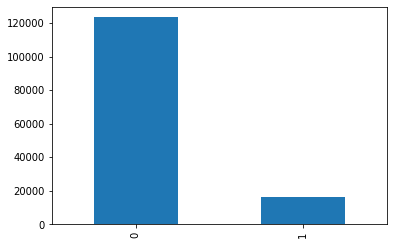

In [46]:
pd.value_counts(dataset['ISIS Flag']).plot.bar()

In [47]:
positive_dataset = dataset[dataset['ISIS Flag'] == 1]
negative_dataset = dataset[dataset['ISIS Flag'] == 0]
print('#positive instances', len(positive_dataset))
print('#negative instances', len(negative_dataset))

#positive instances 16446
#negative instances 123328


## Checking the quality of the text
- Most of the texts seem to be written in English, but there are also texts in other languages
- Texts contain many line breaks and Unicode characters that haven't been correctly interpreted
- Otherwise, the text was successfully exported from the original XLSX file to raw CSV in UTF-8 encoding

In [48]:
positive_dataset.head(20)

,ISIS Flag,Tweet
7,1,"- Breaking! According to Amaq, pro Islamic State media the battle of Palmyra is still in the outskirts of the... https://t.co/afzaskrBuf"
48,1,""" Ingatlah, hanyalah milikNyalah penciptaan dan perintah "" (QS. Al Araf:54)\nJelas! ..Yang menciptakan hanyalah الله، yg berhak memerintah,"
49,1,""" La véritable histoire ...."" surement un bon spectacle humoristique\n\nhttps://t.co/zx2YOjc1B6"
50,1,""" We commited hundreds of thousands of troops to capture Fallujah during the Iraq war, the enemy (Islamic state)... https://t.co/aYSC4A7ajP"
51,1,""" Win the heart of the people first "" 😥\n\n#Save_Fiqh_Waqi 😭\n\nhttps://t.co/56f8M2loVr"
52,1,"""....Le rêve américain ne l’a toujours pas quitté"" #Fin"
53,1,"""29 German soldiers left to join ISIS; army may have dozens more jihadist sympathizers""\n\nhttps://t.co/zFnIxWjKZl"
54,1,"""30 killed, 40 injured after a bombing in ""Sayida Zaynab"" in Damascus"" https://t.co/Bt24AVAe7U"
55,1,"""A Kurdish Convergence in Syria""\n\nhttps://t.co/DDqhHymNcD"
56,1,"""Abbas to Biden: Palestinian State Key to Beating ISIS""\n\nhttps://t.co/2NQf0qkgBU"


In [49]:
negative_dataset.head(20)

,ISIS Flag,Tweet
0,0,-- @kanyewest is doing more to repair race relations than @BarackObama ever did --
1,0,"- \And The best 30 days of our Life has just started!\""\ud83c\udf19\n\u0627\u0644\u062d\u0645\u062f\u0627\u0644\u0644\u0651\u0670\u06c1\ud83c\udf38\nMay Allah enable us to do more and more Good Deeds.. May\u2026"""
2,0,- \ud83c\udf3fE U P H O R I A \ud83c\udf3f- \n\n#iVoteBTSBBMAs @BTS_twt https://t.co/ulRM3mNCtZ
3,0,"- \whos gonna drive you home tonite\""\n- @Uber\n\nhttps://t.co/YafqqusdrV"""
4,0,- 6PM KST\n- FAKE LOVE MV \n- NEW SONGS TO LOVE\n- THE DANCE STEPS WILL KILL US\n- THEIR OUTFITS AND THEIR LOOKS\n- COMEBACK IS S\u2026
5,0,- a happy family https://t.co/QxHelrCAmu
6,0,- A Room for a Man (2017) by Anthony Chidiac \nTrailer: https://t.co/lryJMehbKV\n\n- This Little Father Obsession (201\u2026 https://t.co/mHzMhRSPXT
8,0,- Call me by your name and i'll call you by mine\n- Sherlock\n- Sherlock\n- Sherlock\n- Sherlock\n- Sherlock\n- Sherlock htt\u2026
9,0,-- Calling all researchers! --\n\nWe are going to use this money to make a release (or releases) from the Biobank free of c\u2026
10,0,- EP 1:\nENG title: \u201cGood Evening\u201d\nKRN title: \u201cPick You Up\u201d\n\n- EP 2:\n\u201cI Want You\u201d\n\n- EP 3:\nEng Title: \u201cOur Page\u201d\nKrn Title: \u201cTh\u2026


## Normalization of the text
- It has been needed to normalize those issues. Indeed, without that normalization, the text caused errors when treated by models and several processing tools
- So, as part of the solution of the exercise, a python class intended to normalize text has been implemented
- As can be observed here, a cleaner version of the text can be obtained by performing that kind of normalization

In [50]:
normalized_texts = [normalizer.normalize(text) for text in dataset['Tweet'].to_list()]
normalized_dataset = dataset
normalized_dataset['Normalized'] = normalized_texts
normalized_dataset.head()

,ISIS Flag,Tweet,Normalized
0,0,-- @kanyewest is doing more to repair race relations than @BarackObama ever did --,-- @kanyewest is doing more to repair race relations than @BarackObama ever did --
1,0,"- \And The best 30 days of our Life has just started!\""\ud83c\udf19\n\u0627\u0644\u062d\u0645\u062f\u0627\u0644\u0644\u0651\u0670\u06c1\ud83c\udf38\nMay Allah enable us to do more and more Good Deeds.. May\u2026""","- \And The best 30 days of our Life has just started!\"" الحمداللّٰہ May Allah enable us to do more and more Good Deeds.. May…"""
2,0,- \ud83c\udf3fE U P H O R I A \ud83c\udf3f- \n\n#iVoteBTSBBMAs @BTS_twt https://t.co/ulRM3mNCtZ,- E U P H O R I A - #iVoteBTSBBMAs @BTS_twt https://t.co/ulRM3mNCtZ
3,0,"- \whos gonna drive you home tonite\""\n- @Uber\n\nhttps://t.co/YafqqusdrV""","- \whos gonna drive you home tonite\"" - @Uber https://t.co/YafqqusdrV"""
4,0,- 6PM KST\n- FAKE LOVE MV \n- NEW SONGS TO LOVE\n- THE DANCE STEPS WILL KILL US\n- THEIR OUTFITS AND THEIR LOOKS\n- COMEBACK IS S\u2026,- 6PM KST - FAKE LOVE MV - NEW SONGS TO LOVE - THE DANCE STEPS WILL KILL US - THEIR OUTFITS AND THEIR LOOKS - COMEBACK IS S…


## Checking the languages of the dataset
- Most of the texts have been written in English, but texts in other languages can also be found
- A FastText language identifier has been used to automatically tag every text with its corresponding language
- As can be observed in the bar chart, the vast majority of texts have been written in English
- If the dataset contains 139774 texts, there are only ~750 in Frech, ~500 in German, ~300 in Italian and Spanish. There is a long tail
- However, the ratio of non-English texts is higher in pro-ISIS texts than in the whole dataset

In [51]:
languages = language_identifier.predict(normalized_dataset['Normalized'].to_list())
normalized_dataset_with_languages = normalized_dataset
normalized_dataset_with_languages['Language'] = languages
normalized_dataset_with_languages.head()

,ISIS Flag,Tweet,Normalized,Language
0,0,-- @kanyewest is doing more to repair race relations than @BarackObama ever did --,-- @kanyewest is doing more to repair race relations than @BarackObama ever did --,en
1,0,"- \And The best 30 days of our Life has just started!\""\ud83c\udf19\n\u0627\u0644\u062d\u0645\u062f\u0627\u0644\u0644\u0651\u0670\u06c1\ud83c\udf38\nMay Allah enable us to do more and more Good Deeds.. May\u2026""","- \And The best 30 days of our Life has just started!\"" الحمداللّٰہ May Allah enable us to do more and more Good Deeds.. May…""",en
2,0,- \ud83c\udf3fE U P H O R I A \ud83c\udf3f- \n\n#iVoteBTSBBMAs @BTS_twt https://t.co/ulRM3mNCtZ,- E U P H O R I A - #iVoteBTSBBMAs @BTS_twt https://t.co/ulRM3mNCtZ,en
3,0,"- \whos gonna drive you home tonite\""\n- @Uber\n\nhttps://t.co/YafqqusdrV""","- \whos gonna drive you home tonite\"" - @Uber https://t.co/YafqqusdrV""",en
4,0,- 6PM KST\n- FAKE LOVE MV \n- NEW SONGS TO LOVE\n- THE DANCE STEPS WILL KILL US\n- THEIR OUTFITS AND THEIR LOOKS\n- COMEBACK IS S\u2026,- 6PM KST - FAKE LOVE MV - NEW SONGS TO LOVE - THE DANCE STEPS WILL KILL US - THEIR OUTFITS AND THEIR LOOKS - COMEBACK IS S…,de


<AxesSubplot:>

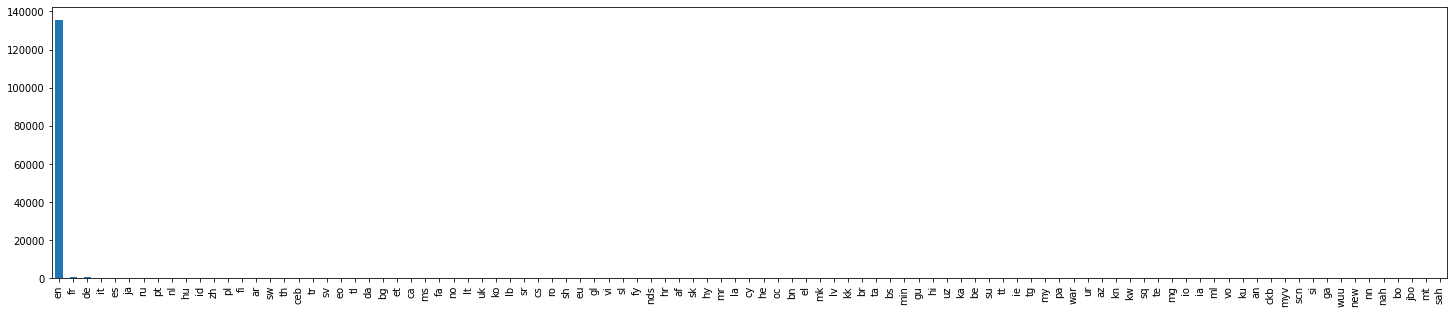

In [52]:
pd.value_counts(normalized_dataset_with_languages['Language']).plot.bar(figsize=(25,5))

#non English tweets: 4017


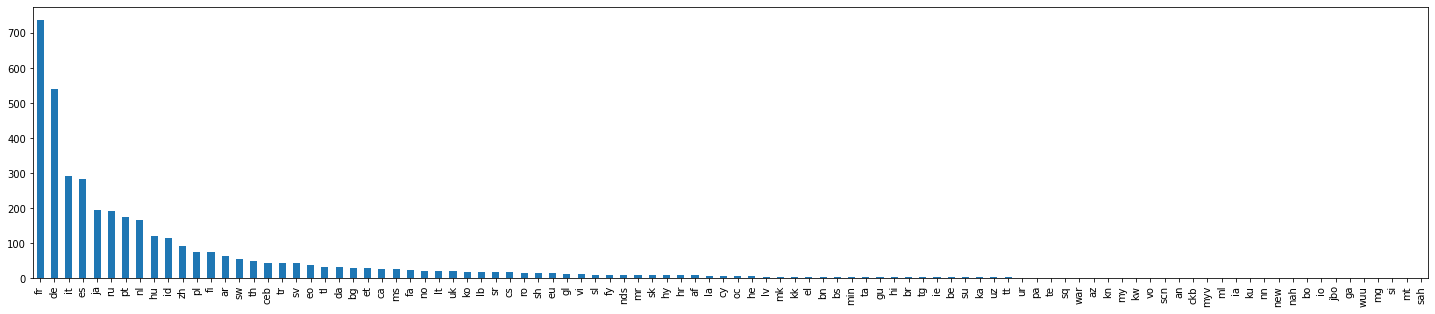

In [53]:
non_english_dataset = normalized_dataset_with_languages[normalized_dataset_with_languages['Language']!='en']
pd.value_counts(non_english_dataset['Language']).plot.bar(figsize=(25,5))
print('#non English tweets:', len(non_english_dataset))

<AxesSubplot:>

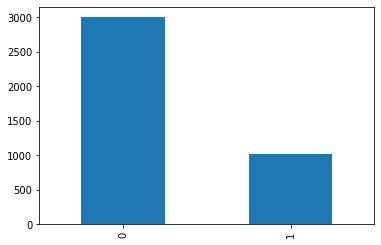

In [54]:
pd.value_counts(non_english_dataset['ISIS Flag']).plot.bar()

## Understanding differences between positive and negative texts
- To decide an approach to solve the problem, an understanding of the content of the texts is needed.
- The following word clouds show the most common words and phrases in every set of texts
- As can be observed, those sets are very different
- At a first glance, it seems that non-pro-ISIS texts deal with any topic; however, pro-ISIS texts seem to focus on more specific topics
- As a baseline at least, it seems that pro-ISIS texts have characteristic words and phrases
- If this hypothesis is correct, the problem of identifying pro-ISIS tweets could be solved as a binary classification problem where the input of the classifier would be a Bag of Words that represents the relevant words or phrases in the text

In [55]:
def get_common_tokens(tokenized_texts=None, n=None):
    dictionary = Dictionary(tokenized_texts)
    return {word[0]: word[1] for word in dictionary.most_common(n=n)}

def create_wordcloud(frequencies):
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(frequencies)
    plt.figure(figsize=(15, 15))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

positive_normalized_dataset = normalized_dataset[normalized_dataset['ISIS Flag']==1]
positive_normalized_texts = positive_normalized_dataset['Normalized'].to_list()
positive_tokenized_texts = [tokenizer.tokenize(text) for text in positive_normalized_texts]

negative_normalized_dataset = normalized_dataset[normalized_dataset['ISIS Flag']==0]
negative_normalized_texts = negative_normalized_dataset['Normalized'].to_list()
negative_tokenized_texts = [tokenizer.tokenize(text) for text in negative_normalized_texts]

phraser = Phraser(tokenized_texts=negative_tokenized_texts + positive_tokenized_texts)
positive_tokenized_texts_with_phrases = [phraser.phrase(text) for text in positive_tokenized_texts]
negative_tokenized_texts_with_phrases = [phraser.phrase(text) for text in negative_tokenized_texts]

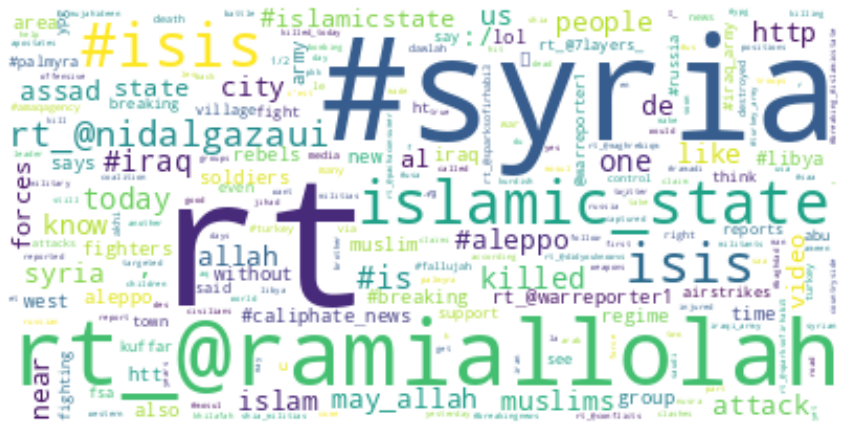

In [56]:
common_tokens_in_positive_dataset = get_common_tokens(positive_tokenized_texts_with_phrases)
create_wordcloud(common_tokens_in_positive_dataset)

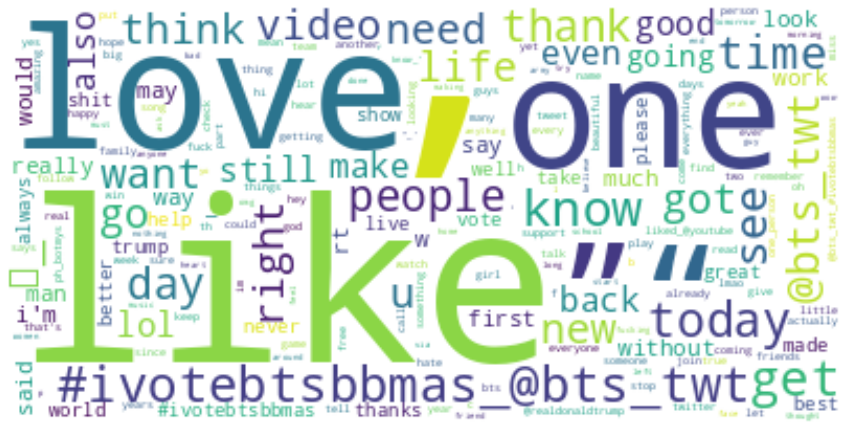

In [57]:
common_tokens_in_negative_dataset = get_common_tokens(negative_tokenized_texts_with_phrases)
create_wordcloud(common_tokens_in_negative_dataset)

## Very few against-ISIS tweets
- The most characteristic words in positive texts appear very little in negative texts
- I may suggest that there are few against-ISIS tweets 

In [58]:
def get_occurrences(tokenized_texts, string):
    """
    Returns the number of texts in which a string
    appear, given a list of tokenized texts
    """
    def has_token(tokenized_text, string):
        for token in tokenized_text:
            if token == string:
                return True
        return False

    counter = 0

    for text in tokenized_texts:
        if has_token(text, string):
            counter = counter + 1

    return counter

print('#ocurrences of isis in negative tweets:', get_occurrences(negative_tokenized_texts, 'isis'))
print('#ocurrences of #isis in negative tweets:', get_occurrences(negative_tokenized_texts, '#isis'))
print('#ocurrences of syria in negative tweets:', get_occurrences(negative_tokenized_texts, 'syria'))
print('#ocurrences of #syria in negative tweets:', get_occurrences(negative_tokenized_texts, '#syria'))

#ocurrences of isis in negative tweets: 32
#ocurrences of #isis in negative tweets: 3
#ocurrences of syria in negative tweets: 19
#ocurrences of #syria in negative tweets: 9
